<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
                                     
def data_view(data):
    
    """
    Функция вызвращает данные о таблице
    """
    return display(data.head(),
                   data.tail(),
                   data.info(), 
                   data.describe(), 
                   data.isna().sum(), 
                   data.duplicated().sum()
                  )

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
data_view(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


datetime      0
num_orders    0
dtype: int64

0

In [4]:
# преобразование даты в нужный формат
df['datetime'] = df['datetime'].astype('datetime64')
# установка даты в качестве индекса и сортировка по возрастанию
data = df.set_index(['datetime']).sort_index()

- Ресемплирование данных по 1 часу (суммарный колличество заказов)

In [5]:
data = data.resample('1H').sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

- Проверка на монотонность

In [6]:
data.index.is_monotonic

True

- Рассмотрим тренд и сезонность

In [7]:
decomposed = seasonal_decompose(data['num_orders'], period=24)

In [8]:
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-31 00:00:00'].index

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 01:00:00',
               '2018-03-01 02:00:00', '2018-03-01 03:00:00',
               '2018-03-01 04:00:00', '2018-03-01 05:00:00',
               '2018-03-01 06:00:00', '2018-03-01 07:00:00',
               '2018-03-01 08:00:00', '2018-03-01 09:00:00',
               ...
               '2018-03-30 15:00:00', '2018-03-30 16:00:00',
               '2018-03-30 17:00:00', '2018-03-30 18:00:00',
               '2018-03-30 19:00:00', '2018-03-30 20:00:00',
               '2018-03-30 21:00:00', '2018-03-30 22:00:00',
               '2018-03-30 23:00:00', '2018-03-31 00:00:00'],
              dtype='datetime64[ns]', name='datetime', length=721, freq='H')

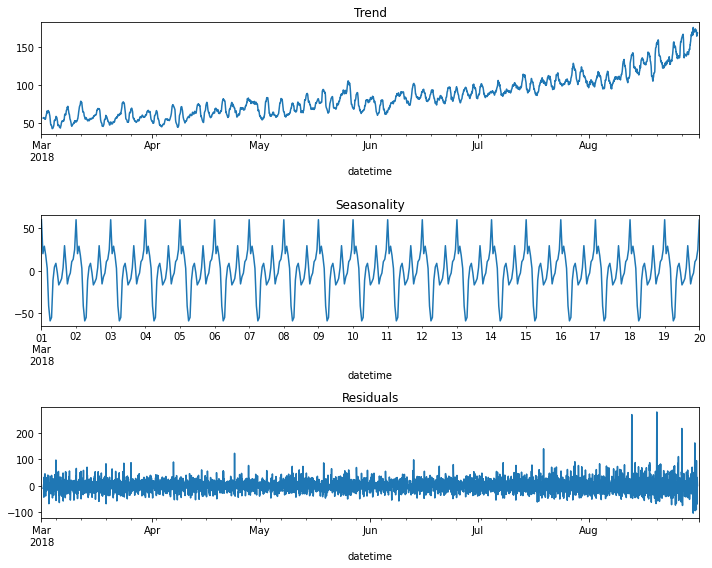

In [9]:
plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed.trend.plot()
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(xlim=('2018-03-01 00:00:00','2018-03-20 00:00:00'))
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot()
plt.title('Residuals')
plt.tight_layout()

- Тест Дики-Фуллера

In [10]:
result = adfuller(data['num_orders'], autolag='AIC')

print('Критерий ADF: %f' % result[0])
print('P-значение: %f' % result[1])
print('Критические значения:')
print(result[4]["5%"])

if result[0] > result[4]["5%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
-2.8621993540813637
Нулевая гипотеза не отвергнута – Временной ряд не стационарен


### Вывод

**- Ряд непрерывный и монотонный. Даты с 2018-03-01 по 2018-08-31**

**- Декомпозиция ряда и тест Дики-Фуллера показали, что ряд не стационарен**

## Обучение

- Добавим признаки для обучения модели

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    
    X_train = pd.DataFrame(data['num_orders'], index=data.index)
    X_train['year'] = X_train.index.year
    X_train['month'] = X_train.index.month
    X_train['day'] = X_train.index.day
    X_train['dayofweek'] = X_train.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        X_train['lag_{}'.format(lag)] = X_train['num_orders'].shift(lag)

    X_train['rolling_mean'] = X_train['num_orders'].rolling(rolling_mean_size, closed='left').mean()
    
    return X_train

- Разделим данные на обучающую и тестовую выборки

In [12]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

### LinearRegression

- Подбираем `lag` и `rolling_size`

In [13]:
def lag_roll_param(model):   
    
    mean_score = 31

    for max_lag in range(2, 36, 2):
        for rolling_mean_size in range(1, 5):

            X_train = make_features(train, max_lag, rolling_mean_size)

            features = X_train.dropna().drop('num_orders', axis=1)
            target = X_train.dropna()['num_orders']

            score = np.mean(cross_val_score(model, 
                                          features, 
                                          target, 
                                          cv=TimeSeriesSplit(), 
                                          scoring='neg_root_mean_squared_error'))
            if round(-score, 1) < mean_score:
                mean_score = -score
                lag, rolling_size = max_lag, rolling_mean_size

    print(
        f'max_lag, rolling_mean_size: {lag, rolling_size}' + '\n'
        + f'best_score = {mean_score}'
    )

In [ ]:
lag_roll_param(LinearRegression())

- Определяем точность модели на тренировочной выборке с учетом `lag` и `rolling_size`

In [14]:
def original_data(data, max_lag, rolling_mean_size):
    
    X_train = make_features(train, max_lag, rolling_mean_size)

    train_features = X_train.dropna().drop('num_orders', axis=1)
    train_target = X_train.dropna()['num_orders']
    
    return train_features, train_target

In [15]:
train_features, train_target = original_data(train, 30, 1)

scaler = StandardScaler()
scaler.fit(train_features)

model = LinearRegression()
model.fit(scaler.transform(train_features), train_target)
pred_train = model.predict(scaler.transform(train_features))

mean_squared_error(train_target, pred_train, squared=False)

25.26189737517972

**- Будем отталкиваться от этого показателя для `LinearRegression`**

### RandomForest

- Подбираем `lag` и `rolling_size` на параметрах модели по умолчанию

In [ ]:
lag_roll_param(RandomForestRegressor())

- Определяем оптимально значение гиперпараметров для случайного леса

In [ ]:
train_features, train_target = original_data(train, 34, 4)

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 50)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]

param_dist = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

        
model = RandomForestRegressor(random_state=12345)
                
rs = RandomizedSearchCV(model, 
                        param_dist,
                        n_iter=25,
                        cv=TimeSeriesSplit(),
                        scoring='neg_root_mean_squared_error',
                        random_state=0)

rs.fit(train_features, train_target)

print(rs.best_params_)
print('RMSE:', rs.best_score_)

### CatBoost

- Подбираем `lag` и `rolling_size` на параметрах модели по умолчанию

In [ ]:
lag_roll_param(CatBoostRegressor(loss_function='RMSE'))

- Определяем оптимально значение гиперпараметров

In [ ]:
train_features, train_target = original_data(train, 28, 1)

grid = {'learning_rate': [0.03, 0.1, 0.13],
        'depth': [4, 6, 10, 12],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

        
model = CatBoostRegressor(loss_function='RMSE', 
                          random_state=12345)
        
train_data = train_features
train_labels = train_target
        
randomized_search_result = model.randomized_search(grid,
                                                   cv=TimeSeriesSplit(),
                                                    X=train_data,
                                                    y=train_labels,
                                                    n_iter=10,
                                                    shuffle=False,
                                                    verbose=False)

randomized_search_result

## Тестирование

In [16]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

- `LinearRegression`

In [17]:
train_features, train_target = original_data(train, 30, 1)

In [18]:
X_test = make_features(test, 30, 1)

test_features = X_test.dropna().drop('num_orders', axis=1)
test_target = X_test.dropna()['num_orders']

In [19]:
scaler = StandardScaler()
scaler.fit(train_features)

model = LinearRegression()
model.fit(scaler.transform(train_features), train_target)
pred_test = model.predict(scaler.transform(test_features))

mean_squared_error(test_target, pred_test, squared=False)

47.25492005994841

<AxesSubplot:xlabel='datetime'>

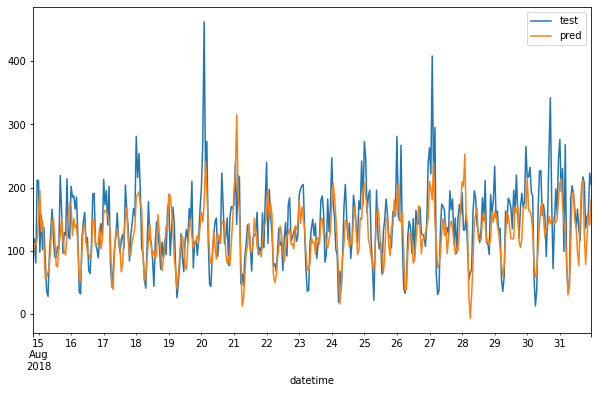

In [20]:
d = {'test': test_target.values , 'pred': pred_test}
pd.DataFrame(data=d, index=test_target.index).plot(figsize=(10, 6))

- `RandomForestRegressor`

In [21]:
train_features, train_target = original_data(train, 34, 4)

In [22]:
X_test = make_features(test, 34, 4)

test_features = X_test.dropna().drop('num_orders', axis=1)
test_target = X_test.dropna()['num_orders']

In [23]:
model = RandomForestRegressor(n_estimators=155, 
                              min_samples_split=18, 
                              min_samples_leaf=7,
                              max_features='sqrt', 
                              max_depth=11,
                              bootstrap=False,
                              random_state=12345)
model.fit(train_features, train_target)
pred_test = model.predict(test_features)

mean_squared_error(test_target, pred_test, squared=False)

47.2084839420964

<AxesSubplot:xlabel='datetime'>

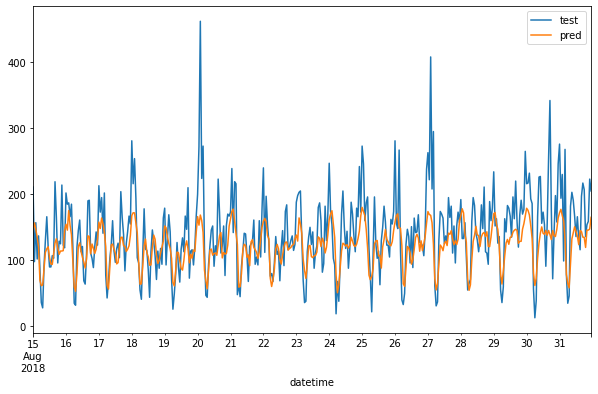

In [24]:
d = {'test': test_target.values , 'pred': pred_test}
pd.DataFrame(data=d, index=test_target.index).plot(figsize=(10, 6))

- `CatBoostRegressor`

In [25]:
train_features, train_target = original_data(train, 28, 1)

In [26]:
X_test = make_features(test, 28, 1)

test_features = X_test.dropna().drop('num_orders', axis=1)
test_target = X_test.dropna()['num_orders']

In [27]:
model = CatBoostRegressor(loss_function='RMSE', 
                          random_state=12345,
                          learning_rate=0.1,
                          depth=6,
                          l2_leaf_reg=1)

model.fit(train_features, train_target)
pred_test = model.predict(test_features)

mean_squared_error(test_target, pred_test, squared=False)

0:	learn: 36.9086673	total: 56ms	remaining: 55.9s
1:	learn: 35.4092311	total: 62.1ms	remaining: 31s
2:	learn: 34.0415982	total: 68.6ms	remaining: 22.8s
3:	learn: 32.8630483	total: 74.5ms	remaining: 18.6s
4:	learn: 31.7885180	total: 80.4ms	remaining: 16s
5:	learn: 30.8464607	total: 86.1ms	remaining: 14.3s
6:	learn: 30.0631345	total: 92.2ms	remaining: 13.1s
7:	learn: 29.3924757	total: 98.2ms	remaining: 12.2s
8:	learn: 28.7997108	total: 104ms	remaining: 11.5s
9:	learn: 28.2586078	total: 110ms	remaining: 10.9s
10:	learn: 27.7535514	total: 116ms	remaining: 10.5s
11:	learn: 27.3065333	total: 123ms	remaining: 10.1s
12:	learn: 26.8799562	total: 129ms	remaining: 9.77s
13:	learn: 26.5569522	total: 135ms	remaining: 9.48s
14:	learn: 26.2393710	total: 141ms	remaining: 9.25s
15:	learn: 25.9843140	total: 148ms	remaining: 9.09s
16:	learn: 25.7273427	total: 154ms	remaining: 8.93s
17:	learn: 25.4527745	total: 162ms	remaining: 8.86s
18:	learn: 25.2675046	total: 169ms	remaining: 8.72s
19:	learn: 25.050974

42.264283916582535

<AxesSubplot:xlabel='datetime'>

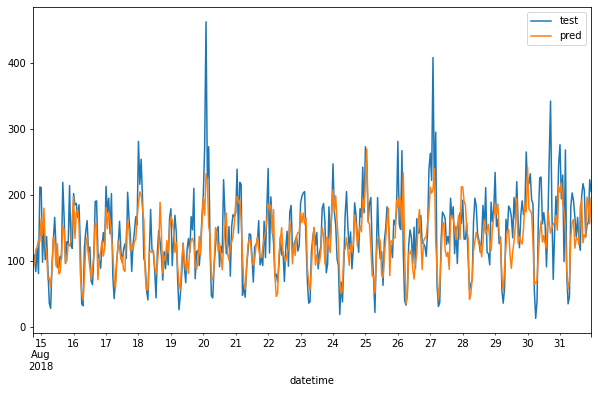

In [28]:
d = {'test': test_target.values , 'pred': pred_test}
pd.DataFrame(data=d, index=test_target.index).plot(figsize=(10, 6))

## Вывод

**- Ряд непрерывный и монотонный. Даты с 2018-03-01 по 2018-08-31**

**- Декомпозиция ряда и тест Дики-Фуллера показали, что ряд не стационарен**

**- В данной работе не требуется проводить ряд к стационарности (ответ преподавателя в канале #project), но вопрос остаётся. (на сколько он нестационарен и необходимо ли принимать меры и какие?)**

**- В целом все модели преодолели необходимый порого качества на тестовой выборке RMSE <= 48, но при разных значениях `lag` и `rolling_size`**

**- Лучшее качество показала модель на тестовой выборке `CatBoostRegressor` при `lag`=28 и `rolling_size`=1**

**- Качество для все моделей в большей степени зависит от `lag` чем от `rolling_size`**